Data wrangling
Dans ce cahier, nous prétraiterons les jeux de données extraits de la base de données MIMIC-III.

In [31]:
# Importer les bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import seaborn as sns
import urllib.request, urllib.parse, urllib.error
import zipfile

# pour avoir des jolies pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('seaborn-notebook')

In [12]:
# générer un dossier de données, nous stockons toutes les données dans ce dossier
if not os.path.exists('data'):
    os.makedirs('data')
    
# téléchargez et décompressez les rawdata
url = 'https://api.onedrive.com/v1.0/shares/u!aHR0cHM6Ly8xZHJ2Lm1zL3UvcyFBdk96S3k0djAydHpndFVwbU1vY1YxSTF6VmJBX2c/root/content'
urllib.request.urlretrieve(url, "download.zip")

with zipfile.ZipFile("download.zip","r") as zip_ref:
    zip_ref.extractall("data/rawdata")

Collecte de données
Les jeux de données sont stockés au format CSV dans le dossier 'data / rawdata'.

In [13]:
def get_path(filename, suffix):
    """Return the path
    
    Args: 
        filename (string): name of the file
        suffix (string): extension of the file
        
    Returns:
        path
    """
# Joindre le chemin du dossier "data"
    cwd = os.getcwd()
    dir_name = os.path.join(cwd, 'data/rawdata')
    
    return os.path.join(dir_name, filename + "." + suffix)


Recueillir les données de caractéristiques qui sont les séries temporelles multivariées
Les fonctionnalités sont stockées dans les fichiers chartdata, labdata et outputdata CSV. D'abord, nous chargeons les données de ces trois fichiers.

In [14]:
# obtenir les noms de fichiers
filenames = ['chartdata',"labdata", "outputdata"]
paths = [get_path(filename, 'csv') for filename in filenames]

# Lire et stocker des données dans une liste
rawdata = []
for path in paths:
    df = pd.read_csv(path, index_col=0, converters={'intime':np.datetime64}, engine='python')
    df.loc[:, 'time'] = pd.to_timedelta(df.loc[:, 'time']) # cast the dtype to timedelta
    rawdata.append(df)

Imprimez les informations des données et les premières lignes des données.

In [15]:
# imprimer les types de données
for i, filename in enumerate(filenames):
    print("Les types de données dans {} sont: \n".format(filename), rawdata[i].dtypes, "\n")
    print("Les 5 premières lignes de {} sont:\n".format(filename), rawdata[i].head(), "\n")

Les types de données dans chartdata sont: 
 icustay_id              int64
intime         datetime64[ns]
time          timedelta64[ns]
category               object
valuenum              float64
dtype: object 

Les 5 premières lignes de chartdata sont:
    icustay_id              intime     time    category  valuenum
0      200003 2199-08-02 19:50:04 00:09:56         GCS       5.0
1      200003 2199-08-02 19:50:04 00:09:56  heart rate     119.0
2      200003 2199-08-02 19:50:04 00:09:56   resp_rate      35.0
3      200003 2199-08-02 19:50:04 00:09:56      sys_BP      91.0
4      200003 2199-08-02 19:50:04 01:09:56  heart rate     122.0 

Les types de données dans labdata sont: 
 icustay_id              int64
intime         datetime64[ns]
time          timedelta64[ns]
category               object
valuenum              float64
dtype: object 

Les 5 premières lignes de labdata sont:
    icustay_id              intime              time   category  valuenum
0      200003 2199-08-02 19:50:04

Nous concaténons ces dataframes selon l'axe = 0. En outre, nous convertissons la colonne 'time' du type timedelta en ajoutant la date actuelle.

In [16]:
# concaténer les rawdata
df = pd.concat(rawdata)
df['time'] = df['time'] + datetime.date.today() # convert the timedelta to datetime 

# Imprimer le fichier de données résultant
df.head()

,icustay_id,intime,time,category,valuenum
0,200003,2199-08-02 19:50:04,2018-05-25 00:09:56,GCS,5.0
1,200003,2199-08-02 19:50:04,2018-05-25 00:09:56,heart rate,119.0
2,200003,2199-08-02 19:50:04,2018-05-25 00:09:56,resp_rate,35.0
3,200003,2199-08-02 19:50:04,2018-05-25 00:09:56,sys_BP,91.0
4,200003,2199-08-02 19:50:04,2018-05-25 01:09:56,heart rate,122.0


Nous faisons ensuite pivoter la table en faisant passer les colonnes en catégories de telle sorte que chaque rangée montre toutes les variables d'une observation, ce qui est un peu plus près des données ordonnées.

In [17]:
# appliquer le pivot à la df
feature_df = df.pivot_table('valuenum', index=['icustay_id', 'time'], columns='category')
feature_df = feature_df.sort_index()
feature_df.head()

category                        BILIRUBIN   BUN  FIO2  GCS  HCO3  PO2   WBC  \
icustay_id time                                                               
200003     2018-05-24 21:49:56        3.5  21.0   NaN  NaN  23.0  NaN  14.8   
           2018-05-25 00:09:56        NaN   NaN   NaN  5.0   NaN  NaN   NaN   
           2018-05-25 00:24:56        NaN   NaN   NaN  NaN   NaN  NaN   NaN   
           2018-05-25 01:09:56        NaN   NaN   NaN  NaN   NaN  NaN   NaN   
           2018-05-25 01:34:56        NaN   NaN   NaN  NaN   NaN  NaN   NaN   

category                        heart rate  potassium  resp_rate  sodium  \
icustay_id time                                                            
200003     2018-05-24 21:49:56         NaN        3.1        NaN   140.0   
           2018-05-25 00:09:56       119.0        NaN       35.0     NaN   
           2018-05-25 00:24:56         NaN        NaN        NaN     NaN   
           2018-05-25 01:09:56       122.0        NaN       34.0     NaN   
           2018-05-25 01:34:56       115.0        NaN       33.0     NaN   

category                        sys_BP  temperature  urine_out  
icustay_id time                                                 
200003     2018-05-24 21:49:56     NaN          NaN        NaN  
           2018-05-25 00:09:56    91.0          NaN        NaN  
           2018-05-25 00:24:56     NaN          NaN      230.0  
           2018-05-25 01:09:56    81.0         39.0        NaN  
           2018-05-25 01:34:56    98.0          NaN        NaN

Recueillir les données cibles, y compris l'étiquette et le score SAPS-II
L'étiquette et le score SAPS-II sont stockés dans les fichiers patient_details et sapsii_score. Nous chargeons les données de ces deux fichiers, puis les combinons ensemble.

In [18]:
# charger les détails du patient à partir du fichier
path = get_path('patient_details', 'csv')
patient_df = pd.read_csv(path, index_col=0)
patient_df = patient_df.set_index('icustay_id').sort_index()
patient_df.head()

,subject_id,hadm_id,gender,dbsource,age,intime,los,survival,in_hospital_death,height_avg,weight_avg
icustay_id,,,,,,,,,,,
200003,27513,163557,M,carevue,48.30,2199-08-02 19:50:04,19.97,75.17,0,NaN,46.4
200007,20707,129310,M,carevue,43.35,2109-02-17 10:03:37,3.24,-1.00,0,153.7,79.9
200014,9514,127229,M,carevue,84.73,2105-02-16 23:16:48,4.60,10.03,0,172.7,96.5
200019,21789,112486,F,carevue,82.88,2178-07-08 09:03:12,2.90,2.62,1,NaN,72.9
200021,61691,109307,M,metavision,60.85,2114-12-26 19:45:12,1.95,-1.00,0,NaN,63.0


In [19]:
# charge le score patient SAPS-II
path = get_path('sapsii_score', 'csv')
sapsii_df = pd.read_csv(path, index_col=0)
sapsii_df = sapsii_df.set_index('icustay_id').sort_index()

# convertit la probabilité en étiquetage
sapsii_df['sapsii_prediction'] = np.where(sapsii_df['sapsii_prob']>0.5, 1, 0)
sapsii_df.head()

,sapsii_prob,sapsii_prediction
icustay_id,,
200003,0.106398,0
200007,0.029295,0
200014,0.305597,0
200019,0.552904,1
200021,0.326364,0


In [20]:
# Créer un dataframe
feature_index = np.sort(feature_df.index.get_level_values('icustay_id').unique().values)
target_df = pd.DataFrame(index = feature_index)
target_df.index.name = 'icustay_id'

# Fusionner le patient_df et sapsii_df ensemble
target_df = pd.concat([target_df, patient_df['in_hospital_death'], sapsii_df], axis = 1, join_axes=[target_df.index])
target_df.head()

,in_hospital_death,sapsii_prob,sapsii_prediction
icustay_id,,,
200003,0,0.106398,0
200007,0,0.029295,0
200014,0,0.305597,0
200019,1,0.552904,1
200021,0,0.326364,0


Nettoyage de données
Copiez l'âge du patient dans la fonction
Nous copions l'âge de patient_df à feature_df. Comme la durée des séjours en USI est courte par rapport à l'âge, on peut supposer que l'âge est une constante dans la série chronologique.

In [21]:
feature_df = pd.merge(feature_df.reset_index(), patient_df['age'].reset_index(), 
                      on="icustay_id").set_index(['icustay_id', 'time'])

In [22]:
feature_df.head()

BILIRUBIN   BUN  FIO2  GCS  HCO3  PO2   WBC  \
icustay_id time                                                               
200003     2018-05-24 21:49:56        3.5  21.0   NaN  NaN  23.0  NaN  14.8   
           2018-05-25 00:09:56        NaN   NaN   NaN  5.0   NaN  NaN   NaN   
           2018-05-25 00:24:56        NaN   NaN   NaN  NaN   NaN  NaN   NaN   
           2018-05-25 01:09:56        NaN   NaN   NaN  NaN   NaN  NaN   NaN   
           2018-05-25 01:34:56        NaN   NaN   NaN  NaN   NaN  NaN   NaN   

                                heart rate  potassium  resp_rate  sodium  \
icustay_id time                                                            
200003     2018-05-24 21:49:56         NaN        3.1        NaN   140.0   
           2018-05-25 00:09:56       119.0        NaN       35.0     NaN   
           2018-05-25 00:24:56         NaN        NaN        NaN     NaN   
           2018-05-25 01:09:56       122.0        NaN       34.0     NaN   
           2018-05-25 01:34:56       115.0        NaN       33.0     NaN   

                                sys_BP  temperature  urine_out   age  
icustay_id time                                                       
200003     2018-05-24 21:49:56     NaN          NaN        NaN  48.3  
           2018-05-25 00:09:56    91.0          NaN        NaN  48.3  
           2018-05-25 00:24:56     NaN          NaN      230.0  48.3  
           2018-05-25 01:09:56    81.0         39.0        NaN  48.3  
           2018-05-25 01:34:56    98.0          NaN        NaN  48.3

Détecter les valeurs aberrantes
Nous obtenons d'abord une brève statistique de la base de données de la fonctionnalité.

In [23]:
feature_df.describe()


,BILIRUBIN,BUN,FIO2,GCS,HCO3,PO2,WBC,heart rate,potassium,resp_rate,sodium,sys_BP,temperature,urine_out,age
count,17413.000000,61019.000000,9781.000000,195545.000000,58402.000000,71477.000000,57305.000000,727503.000000,100003.000000,725291.000000,77621.000000,678309.000000,219675.000000,355367.000000,1.013695e+06
mean,2.122776,26.763787,50.414641,4.047260,23.237726,183.363753,12.365824,85.510838,4.226053,18.841348,138.187536,119.567359,36.896975,138.546588,6.470788e+01
std,4.583922,22.705096,14.479749,1.268771,4.870280,118.540812,10.725286,18.618176,0.786722,5.542793,5.591240,22.951818,0.863139,949.048086,1.774936e+01
min,0.000000,1.000000,0.300000,1.000000,2.000000,10.000000,0.100000,0.350000,0.600000,1.000000,1.210000,0.350000,20.900000,0.300000,1.602000e+01
25%,0.400000,13.000000,40.000000,3.330000,21.000000,94.000000,7.800000,72.000000,3.700000,15.000000,136.000000,103.000000,36.390000,40.000000,5.335000e+01
50%,0.700000,19.000000,50.000000,4.670000,23.000000,143.000000,10.800000,84.000000,4.100000,18.000000,138.000000,117.000000,36.890000,80.000000,6.677000e+01
75%,1.700000,32.000000,60.000000,5.000000,26.000000,251.000000,14.800000,97.000000,4.600000,22.000000,141.000000,134.000000,37.440000,170.000000,7.884000e+01
max,82.800000,272.000000,99.000000,6.000000,53.000000,689.000000,600.200000,222.000000,17.500000,69.000000,182.000000,323.000000,42.780000,555975.000000,9.140000e+01


Basé sur les statistiques, certaines mesures sont loin de la distribution et pourraient être aberrantes. Nous utilisons ensuite le score z pour déterminer les valeurs aberrantes.

(-5, 5)

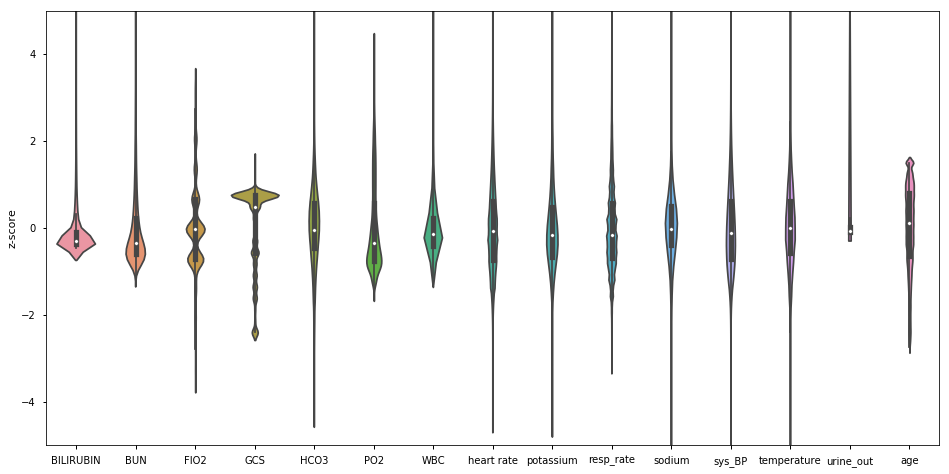

In [24]:
# Calcule le z-score des données
zscore = (feature_df - feature_df.mean()) / feature_df.std()

# Boxplot du z-score 
boxplot_dims = (16, 8)
fig, ax = plt.subplots(figsize=boxplot_dims)
sns.violinplot(ax=ax, data=zscore)
ax.set_ylabel('z-score')
ax.set_ylim([-5,5])

GCS est compris entre 1 et 5, les données hors de cette plage sont considérées comme des valeurs aberrantes. Pour la variable «âge», la fourchette devrait être comprise entre 16 et 91,4 (l'âge maximum). Pour le reste des caractéristiques, nous considérons les observations comme aberrantes si leur z-score est supérieur ou inférieur à 3,5 ou -3,5. Ensuite, nous remplaçons la valeur des valeurs aberrantes par NaN.

In [26]:
# Conditions des valeurs aberrantes
for feature in (set(feature_df.columns) - set(['GCS','age'])):
    feature_df.loc[np.abs(zscore[feature]) > 3.5, feature] = np.nan

# GCS moyen devrait être entre le plus bas (3/3 = 1) au plus haut (15/3 = 5)
feature_df.loc[ (feature_df['GCS'] > 5) | (feature_df['GCS'] < 1), 'GCS'] = np.nan

# La tranche d'âge se situe entre 16 et 91,4
feature_df.loc[ (feature_df['age'] > 91.4) | (feature_df['age'] < 16), 'age'] = np.nan

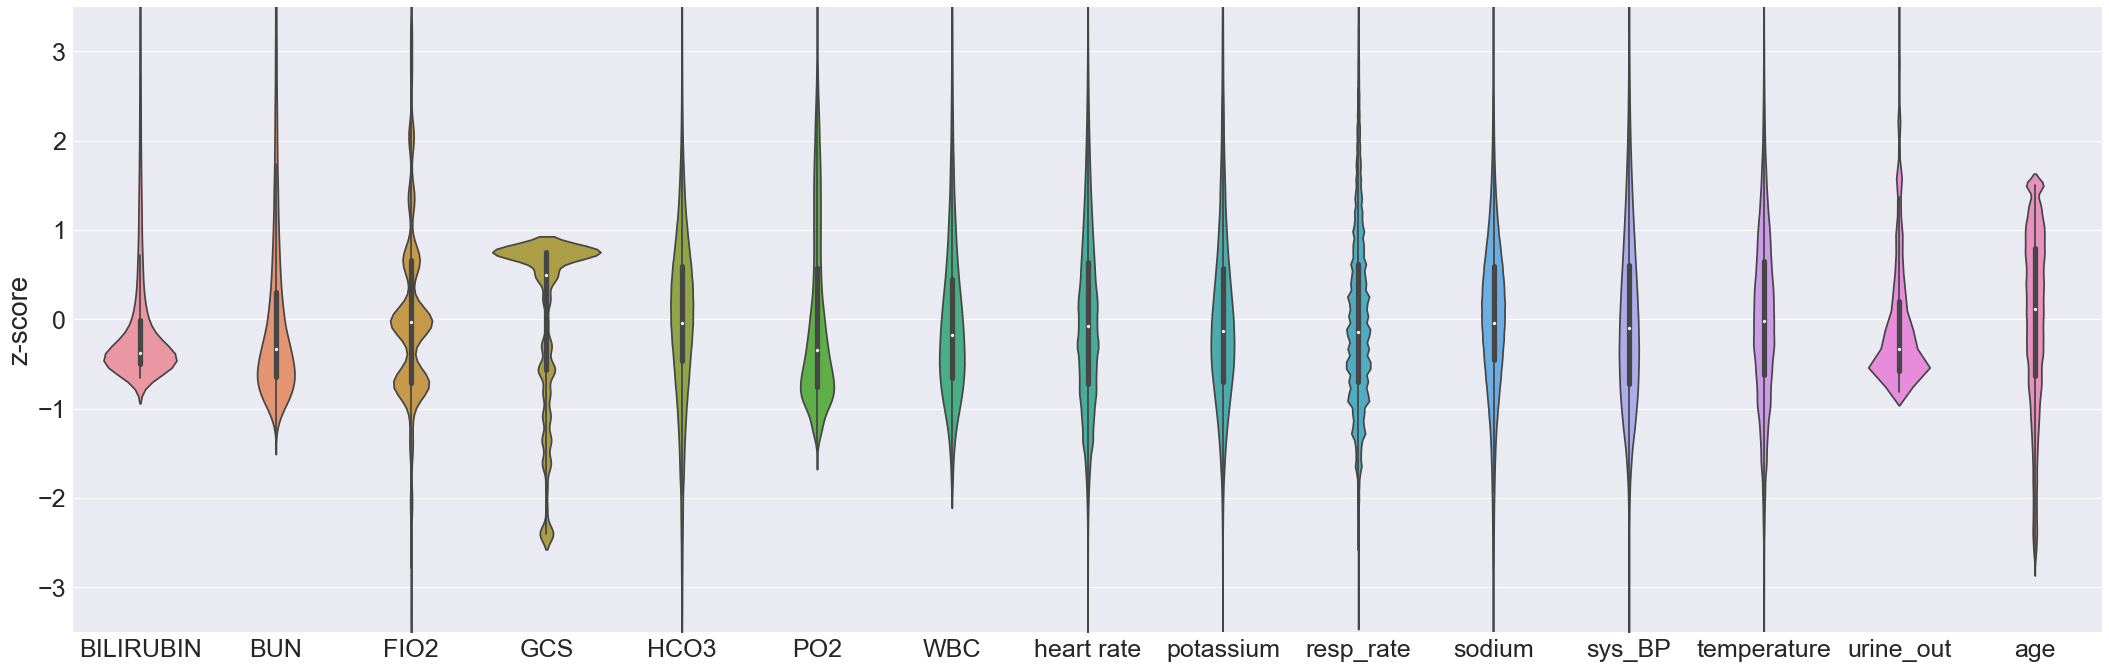

In [27]:
# Calcule le score z des données
zscore = (feature_df - feature_df.mean()) / feature_df.std()

# Boxplot du score z
boxplot_dims = (30, 10)
sns.set(font_scale=2.5)
fig, ax = plt.subplots(figsize=boxplot_dims)
sns.violinplot(ax=ax, data=zscore)
ax.set_ylabel('z-score')
ax.set_ylim([-3.5,3.5])
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.tight_layout()
plt.savefig('plot/distribution_of_z-score')
plt.show() 
plt.close()

Corrélation de fonctionnalité
Ensuite, nous aimerions la corrélation entre chaque fonctionnalité.

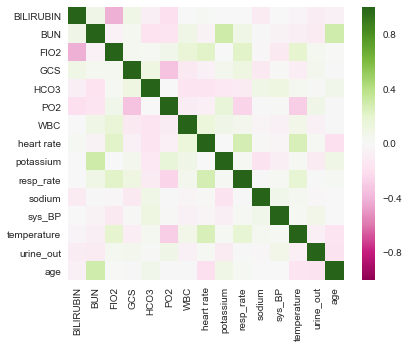

,BILIRUBIN,BUN,FIO2,GCS,HCO3,PO2,WBC,heart rate,potassium,resp_rate,sodium,sys_BP,temperature,urine_out,age
BILIRUBIN,1.000000,0.084949,-0.417520,0.093124,-0.080506,-0.202875,-0.004729,0.017654,-0.000558,-0.003573,-0.107307,-0.005067,-0.032358,-0.100774,-0.060121
BUN,0.084949,1.000000,-0.048806,0.041355,-0.186975,-0.152698,0.087703,-0.039634,0.300214,0.087007,-0.012524,-0.045894,-0.074448,-0.103864,0.291713
FIO2,-0.417520,-0.048806,1.000000,0.033098,0.024963,0.066359,0.168559,0.217693,-0.000389,0.216232,-0.022445,-0.118602,0.200823,0.033038,0.000894
GCS,0.093124,0.041355,0.033098,1.000000,0.104613,-0.336717,-0.123843,-0.058132,0.047847,0.108720,-0.120784,0.014297,-0.089134,0.047995,-0.013157
HCO3,-0.080506,-0.186975,0.024963,0.104613,1.000000,-0.004569,-0.165576,-0.159880,-0.132456,-0.106846,0.090062,0.107411,0.034297,0.007984,0.068086
PO2,-0.202875,-0.152698,0.066359,-0.336717,-0.004569,1.000000,-0.094996,-0.068285,0.159274,-0.251019,-0.012576,0.013034,-0.281525,0.084234,-0.008825
WBC,-0.004729,0.087703,0.168559,-0.123843,-0.165576,-0.094996,1.000000,0.143979,0.085844,0.059692,-0.031238,-0.056317,0.076042,-0.055682,-0.010598
heart rate,0.017654,-0.039634,0.217693,-0.058132,-0.159880,-0.068285,0.143979,1.000000,-0.003631,0.278479,0.009188,-0.030544,0.264115,0.015773,-0.201844
potassium,-0.000558,0.300214,-0.000389,0.047847,-0.132456,0.159274,0.085844,-0.003631,1.000000,0.025003,-0.172057,-0.077325,0.024961,-0.104999,0.093242
resp_rate,-0.003573,0.087007,0.216232,0.108720,-0.106846,-0.251019,0.059692,0.278479,0.025003,1.000000,-0.008487,0.024290,0.175112,-0.008590,0.023649


In [25]:
# calcule la matrice de corrélation
corr_matrix = feature_df.corr()

# tracer la carte de chaleur
boxplot_dims = (6, 5)
sns.set(font_scale=1)
fig, ax = plt.subplots(figsize=boxplot_dims)
sns.heatmap(ax=ax, data=corr_matrix, 
            xticklabels=corr_matrix.columns, 
            yticklabels=corr_matrix.columns,
            cmap='PiYG',
            vmin = -1,
            vmax = 1)
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.tight_layout()
plt.savefig('plot/corr_matrix')
plt.show() 
plt.close()

corr_matrix

Rééchantillonnage, interpolation et imputation des données
Nous rééchantillons les séries chronologiques irrégulières en séries temporelles régulières avec un intervalle de temps de 2 heures. Ensuite, nous interpolons la série chronologique par chaque patient. Enfin, nous imputons l'utilisation de la moyenne si toute la série temporelle est manquante

In [28]:
# Rééchantillonner l'index temporel
time_index = pd.date_range(datetime.date.today(), periods=12, freq='2h', name='time')
resampled_df = feature_df.groupby(level=0).apply(lambda group:group.resample('2h', level=1).mean())
resampled_df = resampled_df.groupby(level=0).apply(lambda group: group.reset_index(level=0, drop=True).reindex(time_index))

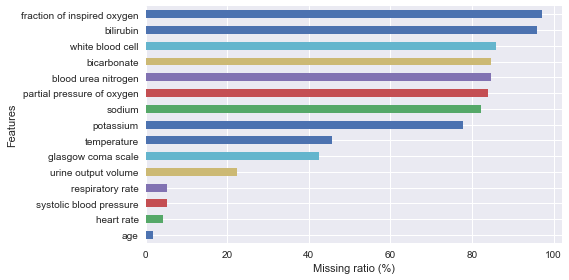

In [32]:
# créer une étiquette
labels = ['bilirubin', 'blood urea nitrogen', 'fraction of inspired oxygen', 'glasgow coma scale', 'bicarbonate', 
          'partial pressure of oxygen', 'white blood cell', 'heart rate', 'potassium', 'respiratory rate',
          'sodium', 'systolic blood pressure', 'temperature', 'urine output volume', 'age']

# calcule le taux manquant
missing_ratio = (100*(1 - resampled_df.count()/resampled_df.shape[0]))

# remplacer l'étiquette
missing_ratio.index = labels

# trier par valeurs
missing_ratio = missing_ratio.sort_values(ascending=True)

# créer une parcelle pour voir le ratio manquant
plot_dims = (8, 4)
fig, ax = plt.subplots(figsize=plot_dims)
missing_ratio.plot(ax=ax, kind = 'barh')
ax.set_ylabel('Features')
ax.set_xlabel('Missing ratio (%)')
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.tight_layout()
plt.savefig('plot/missing_ratio')
plt.show() 
plt.close()

In [33]:
resampled_df.count()

BILIRUBIN       11470
BUN             44356
FIO2             8308
GCS            165978
HCO3            44229
PO2             46203
WBC             40430
heart rate     276461
potassium       64205
resp_rate      273042
sodium          50998
sys_BP         273612
temperature    156495
urine_out      224168
age            283368
dtype: int64

In [37]:
resampled_df.head()

BILIRUBIN   BUN  FIO2  GCS  HCO3   PO2   WBC  \
icustay_id time                                                                
200003     2018-05-25 00:00:00        NaN   NaN   NaN  5.0   NaN   NaN   NaN   
           2018-05-25 02:00:00        NaN   NaN   NaN  NaN   NaN   NaN   NaN   
           2018-05-25 04:00:00        3.4  20.0   NaN  5.0  18.0   NaN  40.2   
           2018-05-25 06:00:00        NaN   NaN   NaN  NaN   NaN  91.0   NaN   
           2018-05-25 08:00:00        NaN   NaN   NaN  NaN   NaN   NaN   NaN   

                                heart rate  potassium  resp_rate  sodium  \
icustay_id time                                                            
200003     2018-05-25 00:00:00  118.200000        NaN      32.60     NaN   
           2018-05-25 02:00:00  114.400000        NaN      31.20     NaN   
           2018-05-25 04:00:00  112.166667        3.2      33.00   141.0   
           2018-05-25 06:00:00  109.000000        NaN      33.25     NaN   
           2018-05-25 08:00:00   93.000000        NaN      37.00     NaN   

                                    sys_BP  temperature  urine_out   age  
icustay_id time                                                           
200003     2018-05-25 00:00:00   89.000000        39.00     230.00  48.3  
           2018-05-25 02:00:00   85.800000        38.03      90.00  48.3  
           2018-05-25 04:00:00   96.333333        36.83     128.50  48.3  
           2018-05-25 06:00:00  104.800000        36.44     263.75  48.3  
           2018-05-25 08:00:00  112.500000          NaN     300.00  48.3

Les données manquantes sont traitées par imputation selon les étapes suivantes:
appliquer une interpolation linéaire sur la série chronologique multivariée pour chaque patient
remplir les données manquantes en utilisant la prochaine observation valide pour chaque patient
Certaines observations sont toujours manquantes après ces imputations, car il y a des données manquantes pour certaines fonctions chez certains patients. Dans ce cas, nous remplissons la série chronologique en utilisant la moyenne de toutes les observations.

In [38]:
from sklearn.preprocessing import Imputer, MinMaxScaler

# Interpoler
resampled_df = resampled_df.groupby(level=0).apply(lambda group: group.interpolate())
resampled_df = resampled_df.groupby(level=0).apply(lambda group: group.fillna(method='backfill'))

# Imputate utilisant la moyenne si toute la série temporelle est manquante
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imputed_data = imp.fit_transform(resampled_df)

# mettre les données à l'échelle de [0,1]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(imputed_data)

# Stocker l'image traitée en tant que processing_df
processed_feature_df = pd.DataFrame(scaled_data, index=resampled_df.index, columns=resampled_df.columns)

In [39]:
processed_feature_df.head()

BILIRUBIN       BUN      FIO2  GCS      HCO3  \
icustay_id time                                                                
200003     2018-05-25 00:00:00   0.187845  0.180952  0.499414  1.0  0.333333   
           2018-05-25 02:00:00   0.187845  0.180952  0.499414  1.0  0.333333   
           2018-05-25 04:00:00   0.187845  0.180952  0.499414  1.0  0.333333   
           2018-05-25 06:00:00   0.191298  0.179762  0.499414  1.0  0.359848   
           2018-05-25 08:00:00   0.194751  0.178571  0.499414  1.0  0.386364   

                                     PO2       WBC  heart rate  potassium  \
icustay_id time                                                             
200003     2018-05-25 00:00:00  0.132075  0.805221    0.749606   0.314815   
           2018-05-25 02:00:00  0.132075  0.805221    0.719685   0.314815   
           2018-05-25 04:00:00  0.132075  0.805221    0.702100   0.314815   
           2018-05-25 06:00:00  0.132075  0.814508    0.677165   0.312500   
           2018-05-25 08:00:00  0.139365  0.823795    0.551181   0.310185   

                                resp_rate    sodium    sys_BP  temperature  \
icustay_id time                                                              
200003     2018-05-25 00:00:00   0.854054  0.578947  0.308176     0.850250   
           2018-05-25 02:00:00   0.816216  0.578947  0.288050     0.688852   
           2018-05-25 04:00:00   0.864865  0.578947  0.354298     0.489185   
           2018-05-25 06:00:00   0.871622  0.588816  0.407547     0.424293   
           2018-05-25 08:00:00   0.972973  0.598684  0.455975     0.420133   

                                urine_out      age  
icustay_id time                                     
200003     2018-05-25 00:00:00   0.067565  0.42823  
           2018-05-25 02:00:00   0.026385  0.42823  
           2018-05-25 04:00:00   0.037709  0.42823  
           2018-05-25 06:00:00   0.077492  0.42823  
           2018-05-25 08:00:00   0.088155  0.42823

Nous illustrons un exemple des données d'origine et des données traitées.

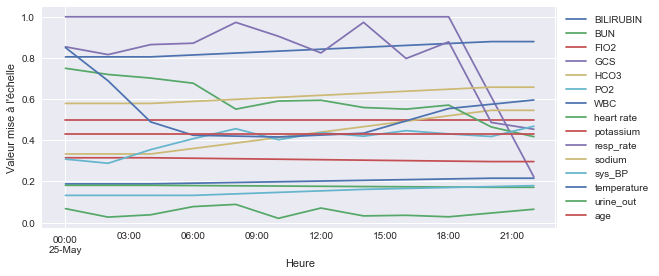

In [31]:
# tracer la série chronologique pour un patient
plot_dims = (8, 4)
fig, ax = plt.subplots(figsize=plot_dims)
processed_feature_df.loc[(200003), :].plot(ax=ax)
ax.set_ylabel("Valeur mise à l'échelle")
ax.set_xlabel('Heure')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.tight_layout()
plt.savefig('plot/An_example_of_imputed_and_transformed_data')
plt.show() 
plt.close()

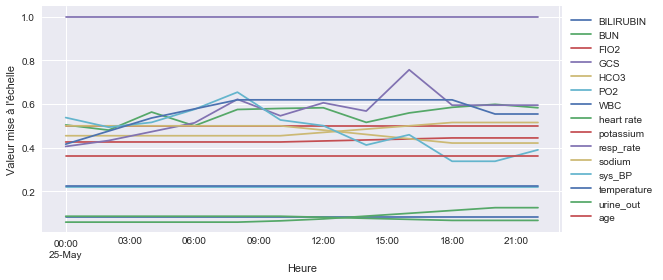

In [40]:
# tracer la série chronologique pour un autre patient
plot_dims = (8, 4)
fig, ax = plt.subplots(figsize=plot_dims)


processed_feature_df.loc[(200007), :].plot(ax=ax)
ax.set_ylabel("Valeur mise à l'échelle")
ax.set_xlabel('Heure')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if not os.path.exists('plot'):
    os.makedirs('plot')
plt.tight_layout()
plt.savefig('plot/An_example_of_imputed_and_transformed_data')
plt.show() 
plt.close()

Créer un train, valide et tester des données

In [36]:
postives = (target_df['in_hospital_death'] == 1).sum()
negatives = (target_df['in_hospital_death'] == 0).sum()
sum_all = postives + negatives
postives = postives/sum_all*100
negatives = negatives/sum_all*100

print('Le pourcentage de positifs et de négatifs: ', postives, negatives)

Le pourcentage de positifs et de négatifs:  11.441771414301174 88.55822858569883


L'ensemble de données est déséquilibré et contient environ 11,4% d'échantillons positifs. Afin de préserver le pourcentage d'échantillons pour chaque classe, une répartition aléatoire stratifiée est appliquée à l'ensemble de données. La taille de la taille de test est définie sur 20% de l'ensemble de données d'origine, qui contient 4806 échantillons. D'un autre côté, l'ensemble de données d'apprentissage contient 19220 échantillons. Enfin, les ensembles de données d'entraînement et de test sont divisés en 'X_train', 'X_test', 'y_train' et 'y_test'.

In [38]:
# Importer train_test_split
#from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Transformer les données en liste de données
features = []
targets = []

for icustay_id, sub_df in processed_feature_df.groupby(level=0):
    features.append(processed_feature_df.loc[icustay_id,:].values)
    targets.append(target_df.loc[icustay_id, :].values)

# considèrer seulement l'étiquette
target_vector = np.array(targets)[:,0] 

# Appliquer stratifiedShuffleSplit pour conserver l'ensemble déséquilibré
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
indexs  = next(iter(sss.split(features, target_vector)))

X_train = [features[index] for index in indexs[0]]
y_train = [targets[index] for index in indexs[0]]
X_test = [features[index] for index in indexs[1]]
y_test = [targets[index] for index in indexs[1]]

# Afficher les résultats de la scission
print("L'ensemble d'entraînement a {} échantillons.".format(len(X_train)))
print("L'ensemble de test a {} échantillons.".format(len(X_test)))

# Check the folds are made by preserving the percentage of samples for each class
difference = abs(sum(np.array(y_train)[:,0])/len(y_train) - sum(np.array(y_test)[:,0])/len(y_test))*100
print("La différence de la fraction d'échantillons positifs entre le train et les jeux de données de test est:{:3f}%".format(difference))

L'ensemble d'entraînement a 19220 échantillons.
L'ensemble de test a 4806 échantillons.
La différence de la fraction d'échantillons positifs entre le train et les jeux de données de test est:0.002821%


Les données de caractéristiques sont une liste de tableaux, et il est préférable de convertir les données qui peuvent être stockées en utilisant le format csv. En outre, supprimez l'ID d'origine ICU-stay et l'intervalle de temps.

In [40]:
# créer un index contient l'identifiant et l'heure pour les données d'apprentissage
time_index = np.arange(0,12,1)
id_index = np.arange(0, len(X_train), 1)
combined_index = pd.MultiIndex.from_product([id_index, time_index], names=['id', 'time'])

# Convertir les données d'apprentissage en données
X_train = pd.DataFrame(np.concatenate(X_train, axis =0), index=combined_index, columns=processed_feature_df.columns)
y_train = pd.DataFrame(np.array(y_train), index=id_index, columns=target_df.columns)
y_train.index.name = 'id'

In [41]:
# Convertir les données d'apprentissage en données
id_index = np.arange(len(y_train), len(y_train) + len(y_test), 1)
combined_index = pd.MultiIndex.from_product([id_index, time_index], names=['id', 'time'])

# convertir les données de test en données
X_test = pd.DataFrame(np.concatenate(X_test, axis=0), index=combined_index, columns=processed_feature_df.columns)
y_test = pd.DataFrame(np.array(y_test), index=id_index, columns=target_df.columns)
y_test.index.name = 'id'

In [42]:
for filename, data in zip(['X_train', 'X_test', 'y_train', 'y_test'], 
                          [X_train, X_test, y_train, y_test]):
    data.to_csv(get_path(filename, 'csv'))

In [43]:
X_train.head()

BILIRUBIN       BUN      FIO2  GCS      HCO3       PO2       WBC  \
id time                                                                     
0  0      0.082443  0.171429  0.499414  1.0  0.484848  0.219736  0.068273   
   1      0.082443  0.171429  0.499414  1.0  0.484848  0.219736  0.068273   
   2      0.082443  0.171429  0.499414  1.0  0.515152  0.219736  0.074297   
   3      0.082443  0.171429  0.499414  1.0  0.545455  0.219736  0.080321   
   4      0.082443  0.171429  0.499414  1.0  0.575758  0.219736  0.086345   

         heart rate  potassium  resp_rate    sodium    sys_BP  temperature  \
id time                                                                      
0  0       0.307087   0.222222   0.513514  0.631579  0.723270     0.564060   
   1       0.232283   0.222222   0.432432  0.631579  0.691824     0.512895   
   2       0.225722   0.305556   0.445946  0.605263  0.603774     0.461730   
   3       0.267717   0.388889   0.500000  0.578947  0.679245     0.397671   
   4       0.275591   0.472222   0.581081  0.552632  0.676101     0.401830   

         urine_out  age  
id time                  
0  0      0.014619  1.0  
   1      0.014619  1.0  
   2      0.058740  1.0  
   3      0.026385  1.0  
   4      0.073448  1.0

In [44]:
X_test.head()

BILIRUBIN       BUN      FIO2  GCS      HCO3       PO2       WBC  \
id    time                                                                     
19220 0      0.082443  0.104762  0.499414  1.0  0.545455  0.219736  0.251004   
      1      0.082443  0.104762  0.499414  1.0  0.545455  0.219736  0.251004   
      2      0.082443  0.104762  0.499414  1.0  0.545455  0.219736  0.251004   
      3      0.082443  0.104762  0.499414  1.0  0.545455  0.219736  0.251004   
      4      0.082443  0.104762  0.499414  1.0  0.545455  0.219736  0.251004   

            heart rate  potassium  resp_rate    sodium    sys_BP  temperature  \
id    time                                                                      
19220 0       0.637795   0.407407   0.567568  0.447368  0.537736     0.720466   
      1       0.669291   0.407407   0.432432  0.447368  0.591195     0.720466   
      2       0.606299   0.407407   0.432432  0.447368  0.522013     0.720466   
      3       0.614173   0.407407   0.513514  0.447368  0.515723     0.697171   
      4       0.511811   0.407407   0.459459  0.447368  0.459119     0.673877   

            urine_out       age  
id    time                       
19220 0      0.035209  0.050279  
      1      0.029326  0.050279  
      2      0.052858  0.050279  
      3      0.041092  0.050279  
      4      0.017560  0.050279

In [45]:
y_train.head()

,in_hospital_death,sapsii_prob,sapsii_prediction
id,,,
0,0.0,0.096698,0.0
1,0.0,0.391926,0.0
2,0.0,0.140051,0.0
3,0.0,0.096698,0.0
4,0.0,0.152870,0.0


In [46]:
y_test.head()

,in_hospital_death,sapsii_prob,sapsii_prediction
id,,,
19220,0.0,0.004584,0.0
19221,0.0,0.079390,0.0
19222,1.0,0.166523,0.0
19223,0.0,0.052195,0.0
19224,0.0,0.305597,0.0
